In [24]:
import numpy as np
import mne
import pyxdf
import matplotlib.pyplot as plt
from mne.io import get_channel_type_constants
import os
import pyntbci
import pandas as pd
from statsmodels.stats.anova import AnovaRM
import seaborn as sns

## CCA

### Cross-validation

['01_cvep_classes=5_bw.npz', '01_cvep_classes=5_grating.npz', '01_cvep_classes=30_bw.npz', '01_cvep_classes=30_grating.npz']
Channels: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, T7, TP7, CP5, CP3, CP1, P1, P3, P5, P7, P9, PO7, PO3, O1, Iz, Oz, POz, Pz, CPz, Fpz, Fp2, AF8, AF4, AFz, Fz, F2, F4, F6, F8, FT8, FC6, FC4, FC2, FCz, Cz, C2, C4, C6, T8, TP8, CP6, CP4, CP2, P2, P4, P6, P8, P10, PO8, PO4, O2

**********
C:\Users\steve\ideaProjects\programming\BCI\Thesis\steven\steven\derivatives\01\01_cvep_classes=5_bw.npz
X shape: (60, 64, 504)
Nan: 0
Unique labels: [0 1 2 3 4]
Label counts: [12 12 12 12 12]
V: [[0 0 1 1 0 0 1 1 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1
  0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1
  1 1 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0
  0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1 1 0 0 1 1
  1 1 0 0 0 0 1 1 1 1 0 0 1 1 1 1 1

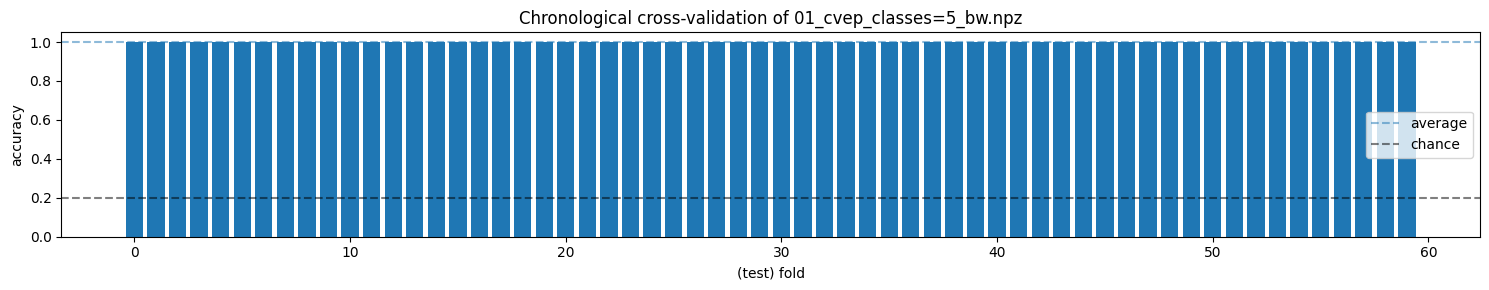

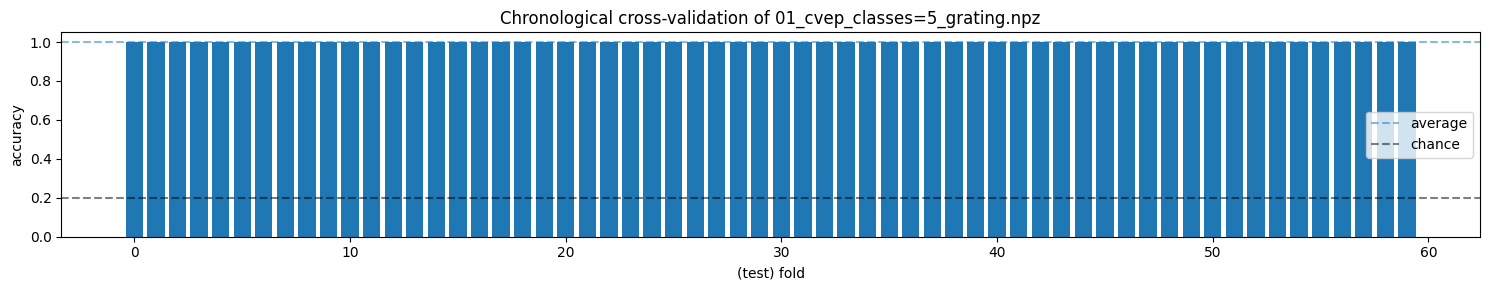

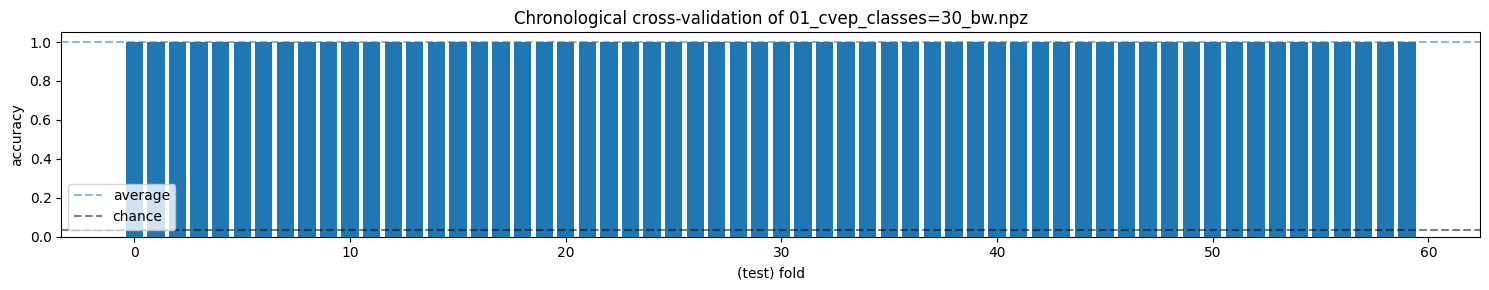

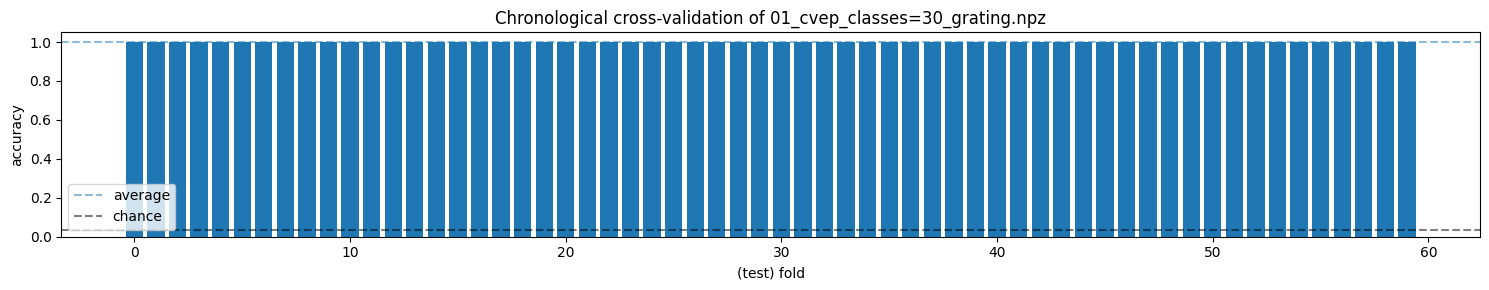

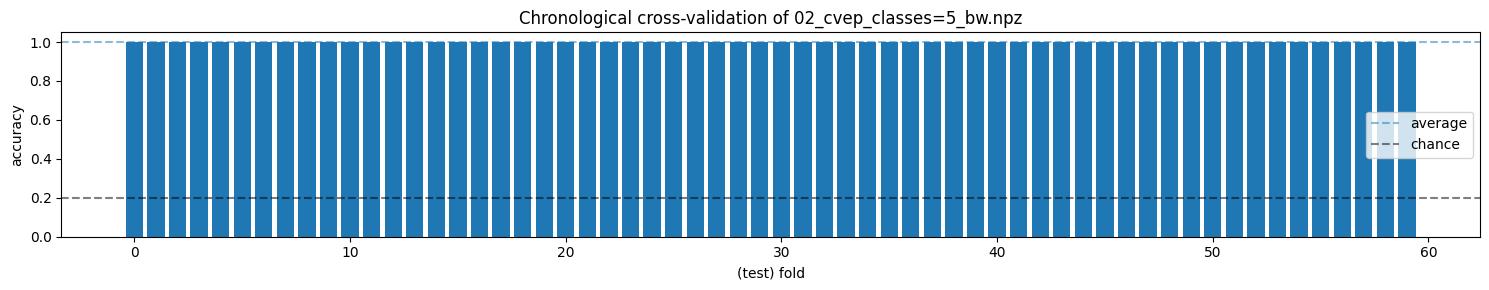

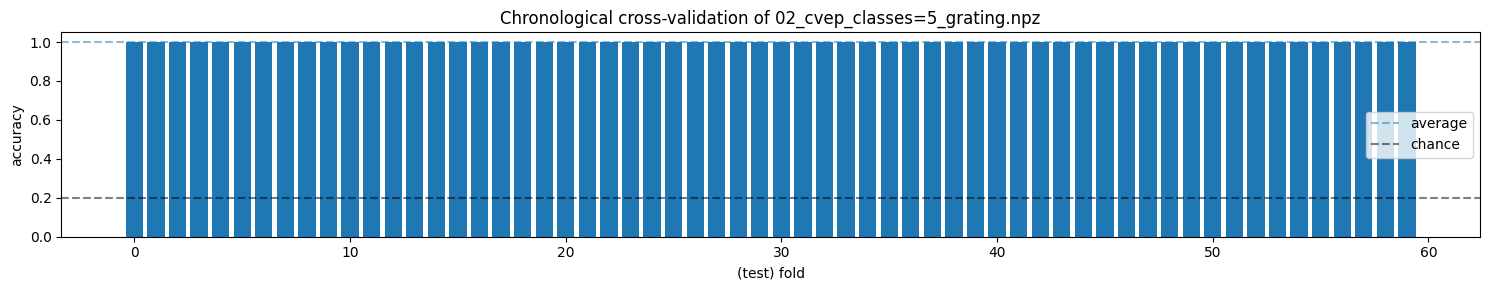

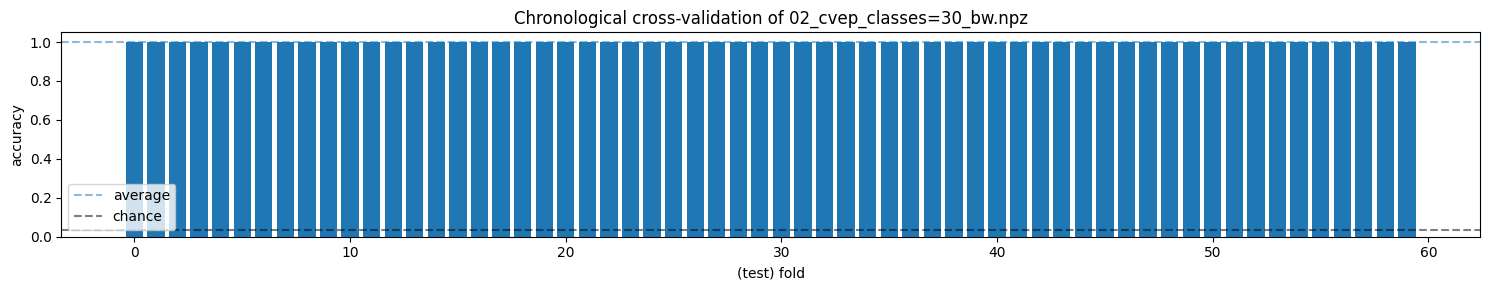

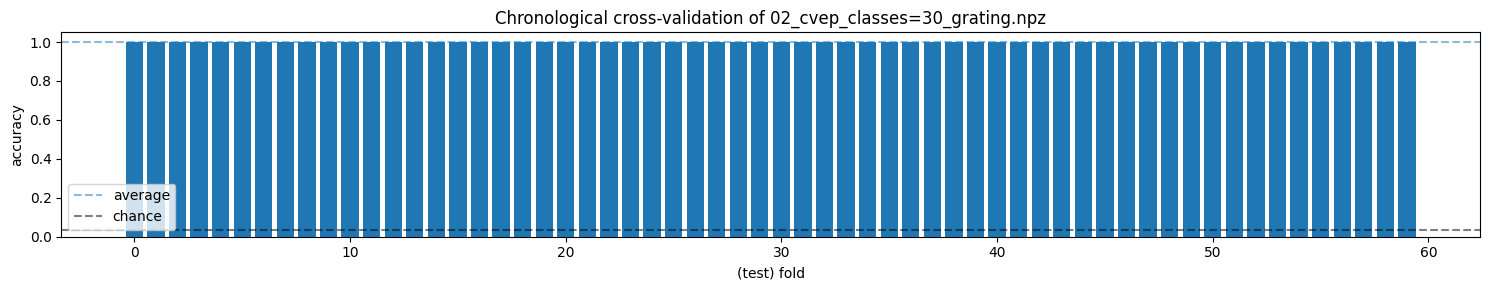

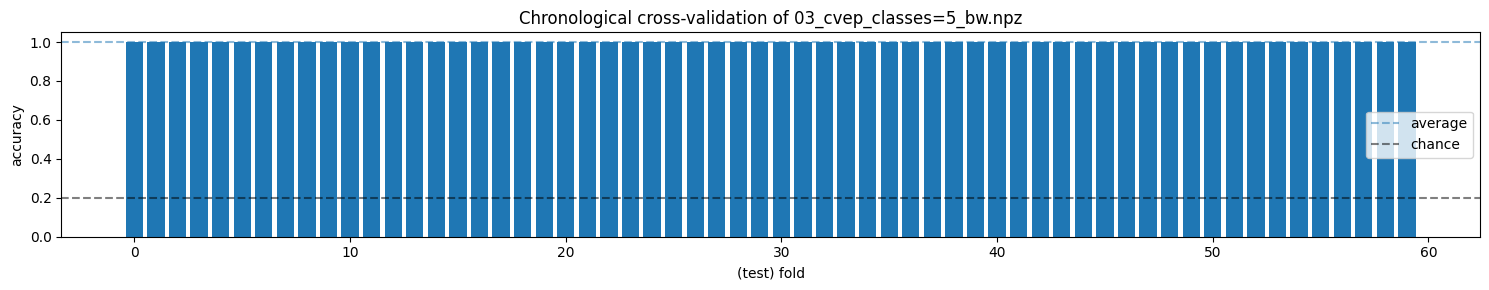

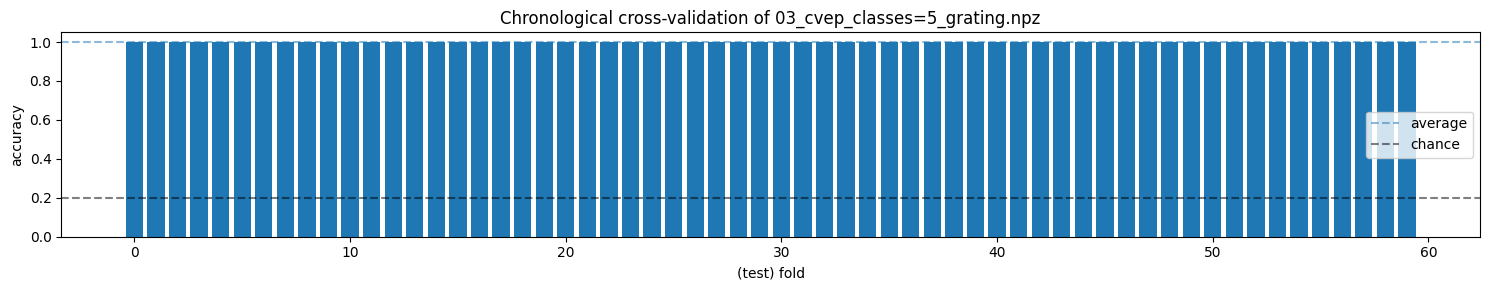

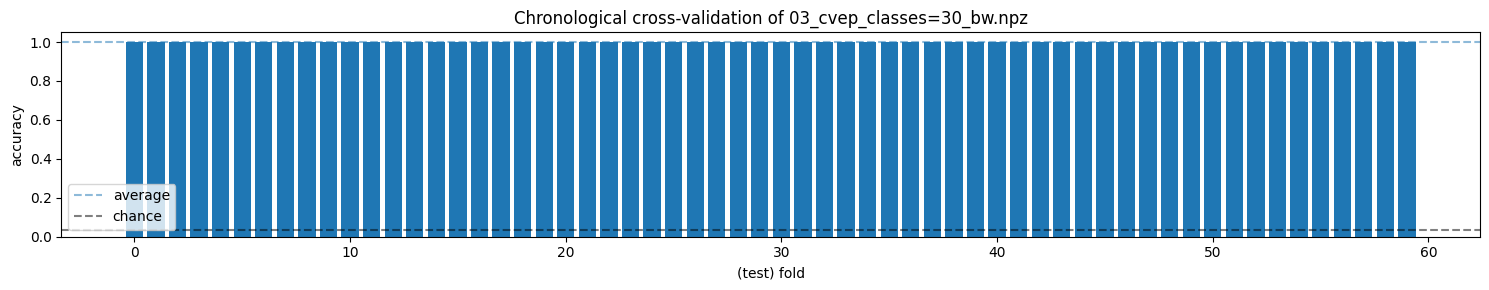

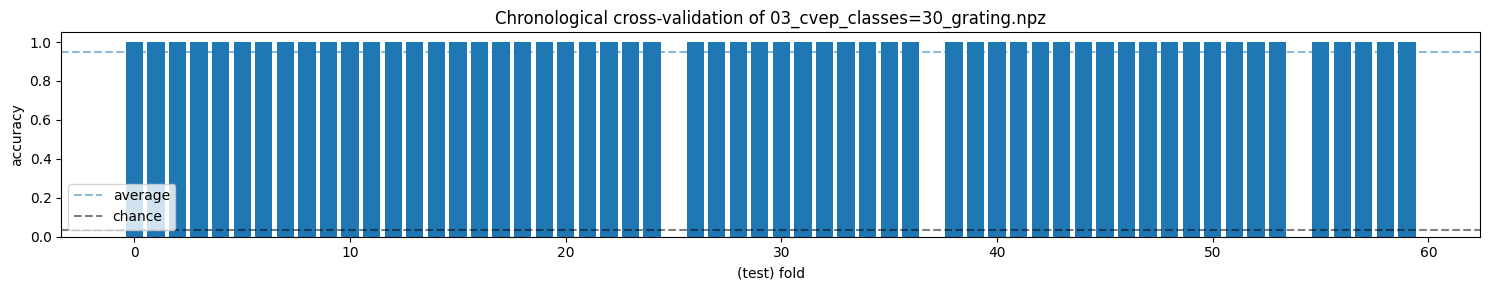

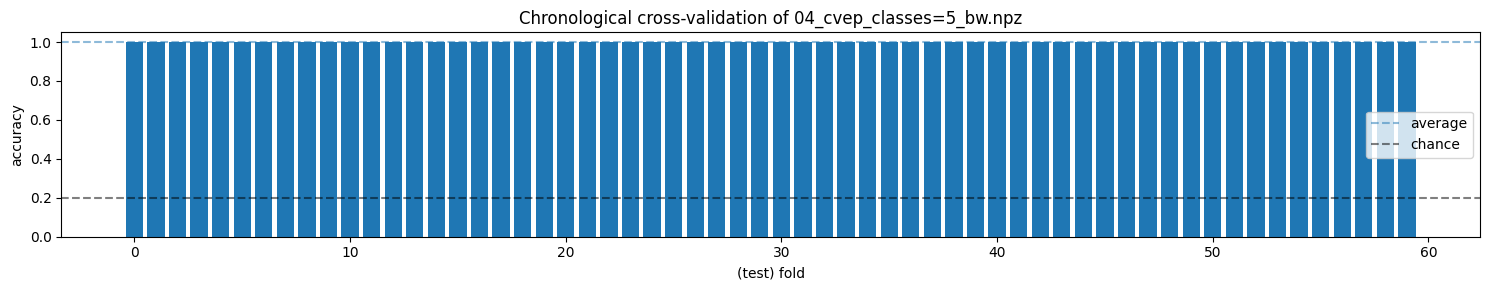

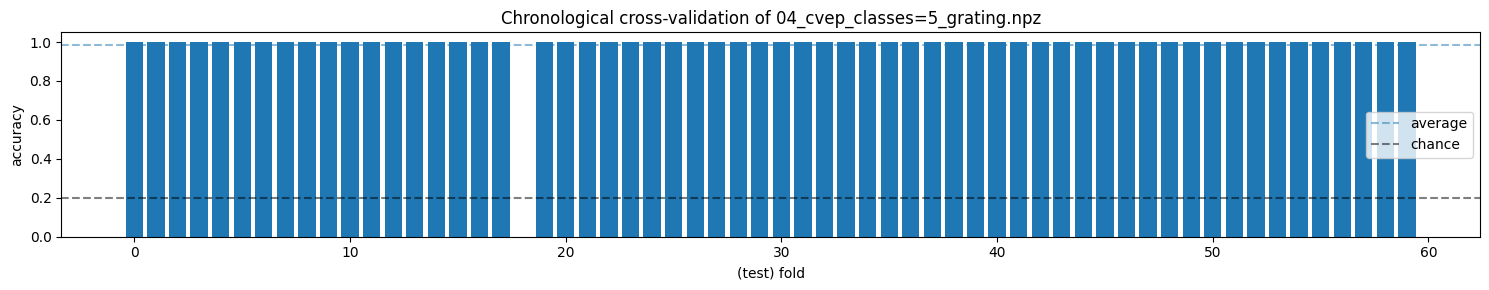

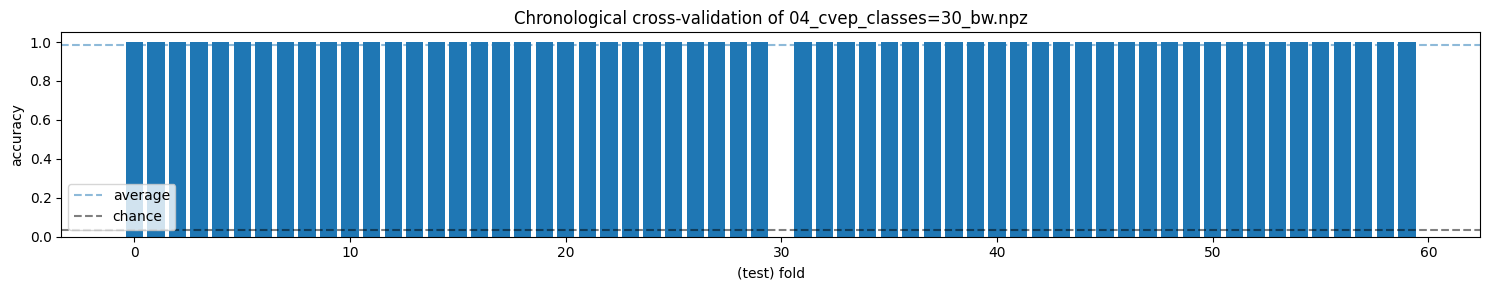

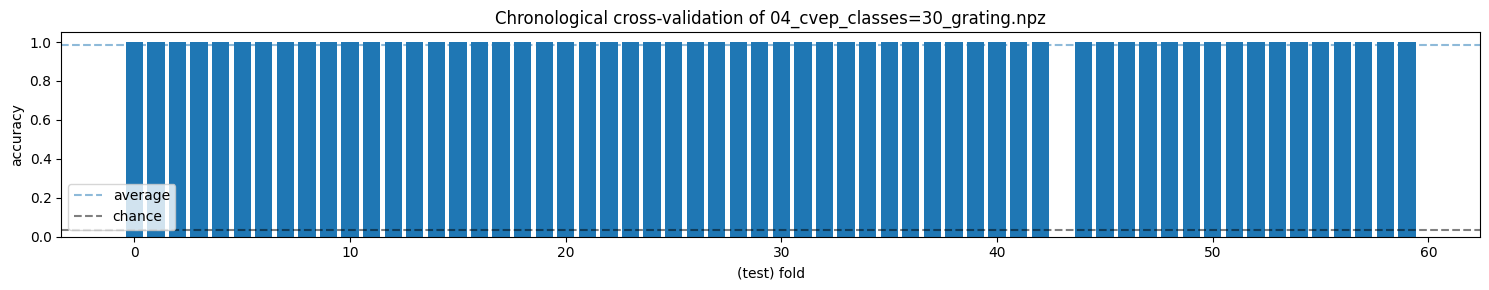

In [2]:
"""
decoding function that calculated the accuracies of the c-VEP offline training for one participant across all four conditions: 5 classes with black-and-white flickers, 
5 classes with grating, 30 classes with black-and-white flickers, 30 classes with grating.

subject: subject number (e.g, "01")
"""
def decode(subject):
    data_dir = os.path.join(os.path.expanduser("~"), "ideaProjects", "programming", "BCI", "Thesis", "steven", "steven")
    folder = os.path.join(data_dir, "derivatives", subject)
    filenames = [f"{subject}_cvep_classes=5_bw.npz", f"{subject}_cvep_classes=5_grating.npz", f"{subject}_cvep_classes=30_bw.npz", f"{subject}_cvep_classes=30_grating.npz"]
    print(filenames)

     # Read cap file
    capfile = os.path.join(data_dir, "data", "biosemi64.loc")
    with open(capfile, "r") as fid:
        channels = []
        for line in fid.readlines():
            channels.append(line.split("\t")[-1].strip())
    print("Channels:", ", ".join(channels))
    
    all_accuracies = []
    
    for filename in filenames:
        print("\n" + 10*"*")
        path = os.path.join(folder, filename)
        print(path)
        data = np.load(path)
        
        # Check the shape of data arrays
        X = data["X"]  # shape: (trials, channels, samples)
        fs = int(data["fs"])
        y = data["y"]
        V = data["V"]

        print("X shape:", X.shape)
        print("Nan:", np.sum(np.isnan(X)))
        
        print("Unique labels:", np.unique(y))
        print("Label counts:", np.bincount(y))
        
        print("V:",V)
        
        if V.shape[0] == 31:
            V = V[:-1]
        print("V.shape:",V.shape)
        
        print("y",y.shape)
        
        #extract data dimensions
        n_trials, n_channels, n_samples = X.shape
        n_classes = V.shape[0]
        
        print("n_trials is:",n_trials)
        
        # Perform CCA
        PR = 60 #60 bits/s
        print("presentation rate:", PR, "/s")
        cycle_size = V.shape[1] / fs  # 2.1 second code cycle length
        print("cycle size is:", cycle_size)
        
        if max(y)+1 == 5:
            lags = np.arange(5) * (12/PR)
        #30 labels
        elif max(y)+1 == 30:
            lags = np.arange(30) * (2/PR)
        else:
            raise ExceptionType("number of classes does not match!")
        print("lag:",lags)

        trialtime = 4.2  # limit trials to a certain duration in seconds
        intertrialtime = 0.8  # ITI in seconds for computing ITR
        n_samples = int(trialtime * fs)
        
        # Chronological cross-validation
        n_folds = n_trials
        folds = np.repeat(np.arange(n_folds), int(n_trials / n_folds))
        print("folds",folds)
        
        # Loop folds
        accuracy = np.zeros(n_folds)
        print(accuracy)
        for i_fold in range(n_folds):
            # Split data to train and valid set
            X_trn, y_trn = X[folds != i_fold, :, :], y[folds != i_fold]
            X_tst, y_tst = X[folds == i_fold, :, :], y[folds == i_fold]
            
            #print("X_train:",X_trn.shape)
            #print("y_train:", y_trn.shape)
            #print("X_test:",X_tst.shape)
            #print("y_test:", y_tst.shape)
        
            #ecca
            ecca = pyntbci.classifiers.eCCA(lags=lags, fs=fs, cycle_size=cycle_size)
            ecca.fit(X_trn, y_trn)
            yh_tst = ecca.predict(X_tst)
        
            # Compute accuracy
            accuracy[i_fold] = np.mean(yh_tst == y_tst)
        
        print("n_classes", n_classes)
        print(V.shape)
        print(accuracy)
        
        # Compute ITR
        itr = pyntbci.utilities.itr(n_classes, accuracy, trialtime + intertrialtime)
        
        # Plot accuracy (over folds)
        plt.figure(figsize=(15, 3))
        plt.bar(np.arange(n_folds), accuracy)
        plt.axhline(accuracy.mean(), linestyle='--', alpha=0.5, label="average")
        plt.axhline(1 / n_classes, color="k", linestyle="--", alpha=0.5, label="chance")
        plt.xlabel("(test) fold")
        plt.ylabel("accuracy")
        plt.legend()
        plt.title(f"Chronological cross-validation of {filename}")
        plt.tight_layout()
        
        # Print accuracy (average and standard deviation over folds)
        print(f"Accuracy: avg={accuracy.mean():.2f} with std={accuracy.std():.2f}")
        print(f"ITR: avg={itr.mean():.1f} with std={itr.std():.2f}")

        all_accuracies.append(accuracy)
        
    return all_accuracies

P1 = decode("01")
P2 = decode("02")
P3 = decode("03")
P4 = decode("04")

# accuracy

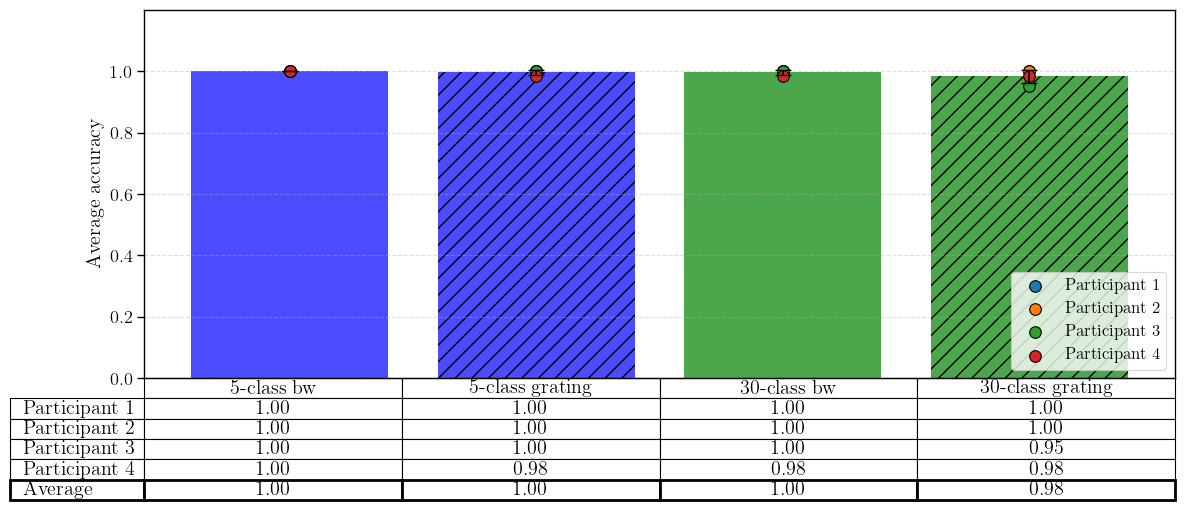

In [3]:
# Compute average accuracy per condition per participant
P1_avg = [np.mean(con) for con in P1]
P2_avg = [np.mean(con) for con in P2]
P3_avg = [np.mean(con) for con in P3]
P4_avg = [np.mean(con) for con in P4]

# Stack into array: shape (4 participants, 4 conditions)
participants = np.array([P1_avg, P2_avg, P3_avg, P4_avg])  # shape: (4, 4)


# Compute group means and stds
mean_accuracies = participants.mean(axis=0)  # shape: (4,)
std_accuracies = participants.std(axis=0)    # shape: (4,)

conditions = [
    "5-class BW",
    "5-class Grating",
    "30-class BW",
    "30-class Grating"
]

colors = ['blue', 'blue', 'green', 'green']
hatches = ['', '//', '', '//']  # Empty string means no hatching

x = np.arange(len(conditions))

sns.set_context("paper", font_scale=1.5)
plt.rc(group='text', usetex=True)
plt.rc(group='font', family='serif')

# Plot bar chart with error bars
plt.figure(figsize=(11.69, 6))
for i in range(len(x)):
    bars = plt.bar(x[i], mean_accuracies[i], yerr=std_accuracies[i], capsize=6, alpha=0.7, color = colors[i], hatch = hatches[i])

# Overlay individual participant data as dots
for i, participant in enumerate(participants):
    plt.scatter(x, participant, label=f"Participant {i+1}", s=70, edgecolors='k')

# Final plot details
plt.xticks(x, conditions)
plt.ylabel("Average accuracy")
plt.ylim(0, 1.2)  # <--- This makes bars "shorter" visually by cutting the lower part
plt.yticks(np.linspace(0, 1.0, 6))  # Tick marks: [0. , 0.2, 0.4, 0.6, 0.8, 1.0]
plt.legend(loc='lower right', fontsize='small')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()


columns = ('5-class bw', '5-class grating', '30-class bw', '30-class grating')
rows = ["Participant 1", "Participant 2","Participant 3", "Participant 4", "Average"]
# Format the cell text: round to 3 or 4 decimal places
cell_text = [[f"{val:.2f}" for val in participant] for participant in participants]
cell_text.append([f"{val:.2f}" for val in mean_accuracies])

# Add a table at the bottom of the axes
the_table = plt.table(cellText=cell_text,
                      rowLabels=rows,
                      colLabels=columns,
                      loc='bottom',
                      cellLoc='center')

# Adjust layout to make room for the table:
the_table.auto_set_font_size(True)

plt.subplots_adjust(left=0.1, bottom=0.35)  # or try 0.4

the_table.scale(1, 1.75) 



# Get number of rows and columns
n_rows = len(rows)
n_cols = len(columns)

# Bold the "Average" row text and increase border thickness
for col in range(n_cols):
    cell = the_table[(n_rows, col)]  # fifth row (index 4)
    cell.set_text_props(weight='bold')
    cell.set_linewidth(2)  # bold cell border

# Bold the row label "Average"
the_table[(n_rows, -1)].set_text_props(weight='bold')
the_table[(n_rows, -1)].set_linewidth(2)



plt.xticks([], [])  # This removes both ticks and tick labels on the x-axis

filename = "accuracy_plot"
plt.savefig(filename, bbox_inches='tight', transparent=False, pad_inches=0.1)
plt.show()



In [4]:
import pandas as pd

# Flat list of participants and conditions
data = []
conditions = ["5-class BW", "5-class Grating", "30-class BW", "30-class Grating"]

for pid, p in enumerate(participants, start=1):
    for cond, acc in zip(conditions, p):
        data.append({
            'Participant': f'P{pid}',
            'Condition': cond,
            'Accuracy': acc
        })

df = pd.DataFrame(data)

# Create new columns for the two within-subject factors
df['Classes'] = df['Condition'].apply(lambda x: '5' if '5-class' in x else '30')
df['Appearance'] = df['Condition'].apply(lambda x: 'bw' if 'BW' in x else 'grating')

print(df)

anova = AnovaRM(df, depvar='Accuracy', subject='Participant', within=['Classes', 'Appearance']).fit()
print(anova)

   Participant         Condition  Accuracy Classes Appearance
0           P1        5-class BW  1.000000       5         bw
1           P1   5-class Grating  1.000000       5    grating
2           P1       30-class BW  1.000000      30         bw
3           P1  30-class Grating  1.000000      30    grating
4           P2        5-class BW  1.000000       5         bw
5           P2   5-class Grating  1.000000       5    grating
6           P2       30-class BW  1.000000      30         bw
7           P2  30-class Grating  1.000000      30    grating
8           P3        5-class BW  1.000000       5         bw
9           P3   5-class Grating  1.000000       5    grating
10          P3       30-class BW  1.000000      30         bw
11          P3  30-class Grating  0.950000      30    grating
12          P4        5-class BW  1.000000       5         bw
13          P4   5-class Grating  0.983333       5    grating
14          P4       30-class BW  0.983333      30         bw
15      

# ITR

n participants: [[ 5  5 30 30]
 [ 5  5 30 30]
 [ 5  5 30 30]
 [ 5  5 30 30]]
participants accuracies: [[1.         1.         1.         1.        ]
 [1.         1.         1.         1.        ]
 [1.         1.         1.         0.95      ]
 [1.         0.98333333 0.98333333 0.98333333]]
decoding time: [[5 5 5 5]
 [5 5 5 5]
 [5 5 5 5]
 [5 5 5 5]]
itr_participants: [[27.86313714 27.86313714 58.88268715 58.88268715]
 [27.86313714 27.86313714 58.88268715 58.88268715]
 [27.86313714 27.86313714 58.88268715 52.53113506]
 [27.86313714 25.99563797 56.44359178 56.44359178]]
mean itr: [27.86313714 27.39626235 58.27291331 56.68502529]
std itr: [0.         0.80865086 1.05615927 2.5967542 ]


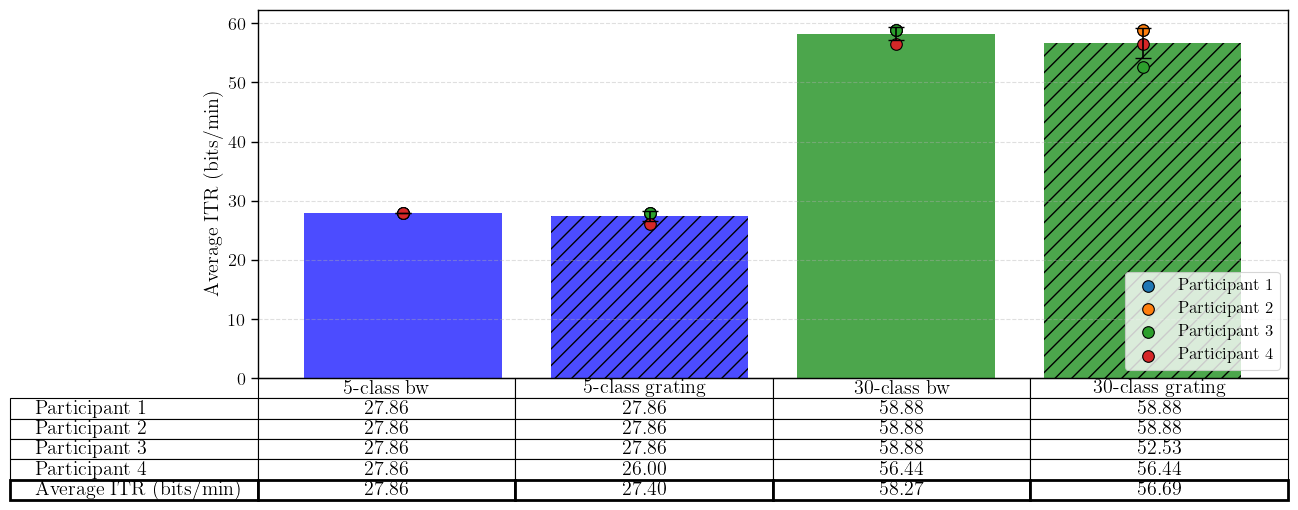

In [5]:
#n = np.array([5,5,30,30])
#t = np.array([5,5,5,5])
#mean_itr = pyntbci.utilities.itr(n,mean_accuracies,t)

# Stack of accuracies into array: shape (4 participants, 4 conditions)
n_participants = np.array([[5,5,30,30],[5,5,30,30],[5,5,30,30],[5,5,30,30]])
participants = np.array([P1_avg, P2_avg, P3_avg, P4_avg])  # shape: (4, 4)
t_participants = np.array([[5,5,5,5],[5,5,5,5],[5,5,5,5],[5,5,5,5]])
itr_participants = pyntbci.utilities.itr(n_participants, participants, t_participants)
mean_itr = itr_participants.mean(axis=0)
std_itr = itr_participants.std(axis=0)
print(f"n participants: {n_participants}")
print(f"participants accuracies: {participants}")
print(f"decoding time: {t_participants}")
print(f"itr_participants: {itr_participants}")
print(f"mean itr: {mean_itr}")
print(f"std itr: {std_itr}")

 

conditions = [
    "5-class BW",
    "5-class Grating",
    "30-class BW",
    "30-class Grating"
]

colors = ['blue', 'blue', 'green', 'green']
hatches = ['', '//', '', '//']  # Empty string means no hatching

x = np.arange(len(conditions))

# Plot bar chart with error bars
plt.figure(figsize=(11.69, 6))
for i in range(len(x)):
    bars = plt.bar(x[i], mean_itr[i], yerr=std_itr[i], capsize=6, alpha=0.7, color = colors[i], hatch = hatches[i])

# Overlay individual participant data as dots
for i, participant in enumerate(itr_participants):
    plt.scatter(x, participant, label=f"Participant {i+1}", s=70, edgecolors='k')

# Final plot details
plt.xticks(x, conditions)
plt.ylabel("Average ITR (bits/min)")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.legend(loc='lower right', fontsize='small')

columns = ('5-class bw', '5-class grating', '30-class bw', '30-class grating')
rows = ["Participant 1 ","Participant 2", "Participant 3", "Participant 4", "Average ITR (bits/min)"]
# Format the cell text: round to 3 or 4 decimal places
cell_text = [[f"{val:.2f}" for val in participant] for participant in itr_participants]
cell_text.append([f"{val:.2f}" for val in mean_itr])


# Add a table at the bottom of the axes
the_table = plt.table(cellText=cell_text,
                      rowLabels=rows,
                      colLabels=columns,
                      loc='bottom',
                      cellLoc='center')

# Adjust layout to make room for the table:
the_table.auto_set_font_size(True)

plt.subplots_adjust(left=0.1, bottom=0.35)  # or try 0.4

the_table.scale(1, 1.75) 

# Get number of rows and columns
n_rows = len(rows)
n_cols = len(columns)

# Bold the "Average" row text and increase border thickness
for col in range(n_cols):
    cell = the_table[(n_rows, col)]  # fifth row (index 4)
    cell.set_text_props(weight='bold')
    cell.set_linewidth(2)  # bold cell border

# Bold the row label "Average"
the_table[(n_rows, -1)].set_text_props(weight='bold')
the_table[(n_rows, -1)].set_linewidth(2)


plt.xticks([], [])  # This removes both ticks and tick labels on the x-axis


filename = "ITR_plot"
plt.savefig(filename, bbox_inches='tight', transparent=False, pad_inches=0.1)
plt.show()

In [34]:
import pandas as pd

# Flat list of participants and conditions
data = []
conditions = ["5-class BW", "5-class Grating", "30-class BW", "30-class Grating"]

for pid, p in enumerate(itr_participants, start=1):
    for cond, acc in zip(conditions, p):
        data.append({
            'Participant': f'P{pid}',
            'Condition': cond,
            'ITR': acc
        })

df = pd.DataFrame(data)

# Create new columns for the two within-subject factors
df['Classes'] = df['Condition'].apply(lambda x: '5' if '5-class' in x else '30')
df['Appearance'] = df['Condition'].apply(lambda x: 'bw' if 'BW' in x else 'grating')

print(df)

anova = AnovaRM(df, depvar='ITR', subject='Participant', within=['Classes', 'Appearance']).fit()
print(anova)

   Participant         Condition        ITR Classes Appearance
0           P1        5-class BW  27.863137       5         bw
1           P1   5-class Grating  27.863137       5    grating
2           P1       30-class BW  58.882687      30         bw
3           P1  30-class Grating  58.882687      30    grating
4           P2        5-class BW  27.863137       5         bw
5           P2   5-class Grating  27.863137       5    grating
6           P2       30-class BW  58.882687      30         bw
7           P2  30-class Grating  58.882687      30    grating
8           P3        5-class BW  27.863137       5         bw
9           P3   5-class Grating  27.863137       5    grating
10          P3       30-class BW  58.882687      30         bw
11          P3  30-class Grating  52.531135      30    grating
12          P4        5-class BW  27.863137       5         bw
13          P4   5-class Grating  25.995638       5    grating
14          P4       30-class BW  56.443592      30    

In [35]:
import numpy as np
from scipy.stats import ttest_rel

itr_5 = df[df['Classes'] == '5'].groupby('Participant')['ITR'].mean()
itr_30 = df[df['Classes'] == '30'].groupby('Participant')['ITR'].mean()
print(itr_5)
print(itr_30)

# Post-HOC ITR_30 > ITR_5
t_stat, p_two_sided = ttest_rel(itr_30, itr_5)
print(t_stat)
print(p_two_sided)
if t_stat > 0:
    p_one_sided = p_two_sided /2
else:
    p_one_sided = 1 - (p_two_sided /2)

# Print results
print(f"Post-hoc one-sided t-test that the 30 class condition results in a higher ITR")
print(f"t({len(itr_5)-1}) = {t_stat:.3f}, one-sided p = {p_one_sided:.7f}")




Participant
P1    27.863137
P2    27.863137
P3    27.863137
P4    26.929388
Name: ITR, dtype: float64
Participant
P1    58.882687
P2    58.882687
P3    55.706911
P4    56.443592
Name: ITR, dtype: float64
39.44016389469959
3.586331455822157e-05
Post-hoc one-sided t-test that the 30 class condition results in a higher ITR
t(3) = 39.440, one-sided p = 0.0000179


# user comfort results

In [17]:
#5bw, 5g, 30bw, 30g (out of 10):
P1_comfort_5bw = np.array([6.7, 8.6]) *10/13.6
P1_comfort_5g = np.array([3.2, 5.4]) *10/13.6
P1_comfort_30bw = np.array([2.9, 3.5])*10/13.6
P1_comfort_30g = np.array([3.5, 3.6])*10/13.6

P1_fatique_5bw = np.array([9.2, 8.2])*10/13.6
P1_fatique_5g = np.array([5.9, 5.3])*10/13.6
P1_fatique_30bw = np.array([1.2, 7.7])*10/13.6
P1_fatique_30g = np.array([7.0, 8.8])*10/13.6

P1_distr_5bw = np.array([4.4, 4.5])*10/13.6
P1_distr_5g = np.array([2.6,  2.6])*10/13.6
P1_distr_30bw = np.array([8.1, 9.1])*10/13.6
P1_distr_30g = np.array([6.9, 3.3])*10/13.6




P2_comfort_5bw = np.array([5.4, 4.6])*10/13.6
P2_comfort_5g = np.array([0.9, 1.5])*10/13.6
P2_comfort_30bw = np.array([7.3, 6.4])*10/13.6
P2_comfort_30g = np.array([1.7, 2.7])*10/13.6

P2_fatique_5bw = np.array([5.3, 5.0])*10/13.6
P2_fatique_5g = np.array([2.9, 0.9])*10/13.6
P2_fatique_30bw = np.array([6.7, 6.9])*10/13.6
P2_fatique_30g = np.array([0.9, 3.3])*10/13.6

P2_distr_5bw = np.array([5.2, 5.0])*10/13.6
P2_distr_5g = np.array([3.1, 2.0])*10/13.6
P2_distr_30bw = np.array([8.1, 7.4])*10/13.6
P2_distr_30g = np.array([3.0, 2.6])*10/13.6




P3_comfort_5bw = np.array([5.8, 3.8])*10/13.6
P3_comfort_5g = np.array([4.4, 3.7])*10/13.6
P3_comfort_30bw = np.array([7.8, 4.9])*10/13.6
P3_comfort_30g = np.array([4.4, 4.0])*10/13.6

P3_fatique_5bw = np.array([6.8, 3.4])*10/13.6
P3_fatique_5g = np.array([8.8, 2.9])*10/13.6
P3_fatique_30bw = np.array([7.7, 7.4])*10/13.6
P3_fatique_30g = np.array([7.3, 3.8])*10/13.6

P3_distr_5bw = np.array([4.1, 5.7])*10/13.6
P3_distr_5g = np.array([7.7, 6.4])*10/13.6
P3_distr_30bw = np.array([8.1, 7.2])*10/13.6
P3_distr_30g = np.array([7.0, 4.2])*10/13.6





P4_comfort_5bw = np.array([7.1, 8.6])*10/13.6
P4_comfort_5g = np.array([1.8, 1.8])*10/13.6
P4_comfort_30bw = np.array([9.2, 8.9])*10/13.6
P4_comfort_30g = np.array([3.8, 3.1])*10/13.6

P4_fatique_5bw = np.array([5.4, 9.1])*10/13.6
P4_fatique_5g = np.array([2.5, 2.0])*10/13.6
P4_fatique_30bw = np.array([8.6, 9.3])*10/13.6
P4_fatique_30g = np.array([5.8, 3.2])*10/13.6

P4_distr_5bw = np.array([6.2, 9.1])*10/13.6
P4_distr_5g = np.array([1.2, 1.5])*10/13.6
P4_distr_30bw = np.array([9.4, 9.9])*10/13.6
P4_distr_30g = np.array([2.9, 4.4])*10/13.6

## visual comfort

amount of eyestrain for 5bw: 4.650735294117647
amount of eyestrain for 30bw: 4.678308823529411
amount of eyestrain for 5g: 2.08639705882353
amount of eyestrain for 30g: 2.463235294117647
LOLOLOL [array([2.57352941, 2.64705882]), array([1.25      , 1.98529412]), array([3.23529412, 2.94117647]), array([2.79411765, 2.27941176])]


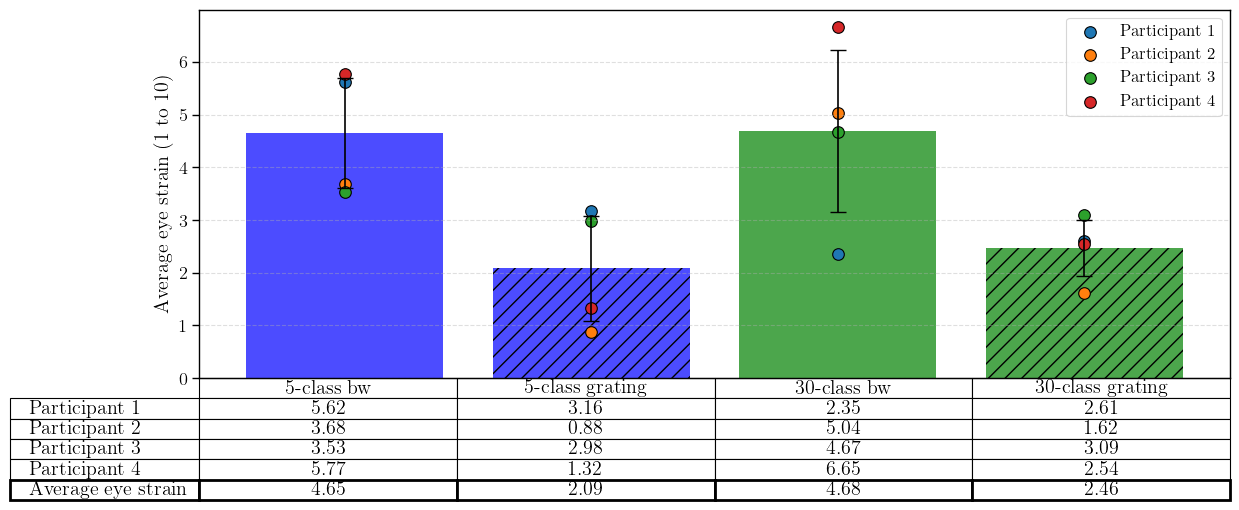

C:\Users\steve\IdeaProjects\programming\BCI\Thesis\steven\Thesis\data


In [28]:
comfort_5bw = [P1_comfort_5bw,P2_comfort_5bw,P3_comfort_5bw,P4_comfort_5bw]
comfort_30bw = [P1_comfort_30bw, P2_comfort_30bw,P3_comfort_30bw,P4_comfort_30bw]
comfort_5g = [P1_comfort_5g, P2_comfort_5g, P3_comfort_5g, P4_comfort_5g]
comfort_30g = [P1_comfort_30g,P2_comfort_30g,P3_comfort_30g,P4_comfort_30g]

comfort_5bw_averaged = np.mean(comfort_5bw, axis = 1)
comfort_5bw_mean = np.mean(comfort_5bw_averaged)
comfort_5bw_std = np.std(comfort_5bw_averaged)

comfort_30bw_averaged = np.mean(comfort_30bw, axis = 1)
comfort_30bw_mean = np.mean(comfort_30bw_averaged)
comfort_30bw_std = np.std(comfort_30bw_averaged)

comfort_5g_averaged = np.mean(comfort_5g, axis = 1)
comfort_5g_mean = np.mean(comfort_5g_averaged)
comfort_5g_std = np.std(comfort_5g_averaged)

comfort_30g_averaged = np.mean(comfort_30g, axis = 1)
comfort_30g_mean = np.mean(comfort_30g_averaged)
comfort_30g_std = np.std(comfort_30g_averaged)

comfort = [comfort_5bw_mean, comfort_5g_mean, comfort_30bw_mean, comfort_30g_mean]
comfort_std = [comfort_5bw_std,comfort_5g_std,comfort_30bw_std,comfort_30g_std]

comfort_per_participant = np.array([
    comfort_5bw_averaged,
    comfort_5g_averaged,
    comfort_30bw_averaged,
    comfort_30g_averaged
]).T

print(f"amount of eyestrain for 5bw: {comfort_5bw_mean}")
print(f"amount of eyestrain for 30bw: {comfort_30bw_mean}")
print(f"amount of eyestrain for 5g: {comfort_5g_mean}")
print(f"amount of eyestrain for 30g: {comfort_30g_mean}")

print(f"LOLOLOL {comfort_30g}")
conditions = [
    "5-class BW",
    "5-class Grating",
    "30-class BW",
    "30-class Grating"
]
x = np.arange(len(conditions))

# Plot bar chart with error bars
plt.figure(figsize=(11.69, 6))
for i in range(len(x)):
    bars = plt.bar(x[i], comfort[i], yerr = comfort_std[i], capsize=6, alpha=0.7, color = colors[i], hatch = hatches[i])

# Overlay individual participant data as dots
for i, participant in enumerate(comfort_per_participant):
    plt.scatter(x, participant, label=f"Participant {i+1}", s=70, edgecolors='k')

# Final plot details
plt.xticks(x, conditions)
plt.ylabel("Average eye strain (1 to 10)")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.legend(loc='upper right', fontsize='small')

columns = ('5-class bw', '5-class grating', '30-class bw', '30-class grating')
rows = ["Participant 1 ","Participant 2", "Participant 3", "Participant 4","Average eye strain"]
# Format the cell text: round to 3 or 4 decimal places
#cell_text = [comfort]
cell_text = [[f"{val:.2f}" for val in participant] for participant in comfort_per_participant]
cell_text.append([f"{val:.2f}" for val in comfort])

# Add a table at the bottom of the axes
the_table = plt.table(cellText=cell_text,
                      rowLabels=rows,
                      colLabels=columns,
                      loc='bottom',
                      cellLoc='center')

# Adjust layout to make room for the table:
the_table.auto_set_font_size(True)

plt.subplots_adjust(left=0.1, bottom=0.35)  # or try 0.4

the_table.scale(1, 1.75) 

# Get number of rows and columns
n_rows = len(rows)
n_cols = len(columns)

# Bold the "Average" row text and increase border thickness
for col in range(n_cols):
    cell = the_table[(n_rows, col)]  # fifth row (index 4)
    cell.set_text_props(weight='bold')
    cell.set_linewidth(2)  # bold cell border

# Bold the row label "Average"
the_table[(n_rows, -1)].set_text_props(weight='bold')
the_table[(n_rows, -1)].set_linewidth(2)

plt.xticks([], [])  # This removes both ticks and tick labels on the x-axis


filename = "comfort_plot1"
plt.savefig(filename, bbox_inches='tight', transparent=False, pad_inches=0.1)
plt.show()

print(os.getcwd())


In [ ]:
import pandas as pd

# Flat list of participants and conditions
data = []
conditions = ["5-class BW", "5-class Grating", "30-class BW", "30-class Grating"]

for pid, p in enumerate(comfort_per_participant, start=1):
    for cond, acc in zip(conditions, p):
        data.append({
            'Participant': f'P{pid}',
            'Condition': cond,
            'Comfort': acc
        })

df = pd.DataFrame(data)

# Create new columns for the two within-subject factors
df['Classes'] = df['Condition'].apply(lambda x: '5' if '5-class' in x else '30')
df['Appearance'] = df['Condition'].apply(lambda x: 'bw' if 'BW' in x else 'grating')

print(df)

anova = AnovaRM(df, depvar='Comfort', subject='Participant', within=['Classes', 'Appearance']).fit()
print(anova)

## fatigue

In [ ]:
fatique_5bw = [P1_fatique_5bw,P2_fatique_5bw,P3_fatique_5bw,P4_fatique_5bw]
fatique_30bw = [P1_fatique_30bw, P2_fatique_30bw,P3_fatique_30bw,P4_fatique_30bw]
fatique_5g = [P1_fatique_5g, P2_fatique_5g, P3_fatique_5g, P4_fatique_5g]
fatique_30g = [P1_fatique_30g,P2_fatique_30g,P3_fatique_30g,P4_fatique_30g]

fatique_5bw_averaged = np.mean(fatique_5bw, axis = 1)
fatique_5bw_mean = np.mean(fatique_5bw_averaged) 
fatique_5bw_std = np.std(fatique_5bw_averaged)

fatique_30bw_averaged = np.mean(fatique_30bw, axis = 1)
fatique_30bw_mean = np.mean(fatique_30bw_averaged)
fatique_30bw_std = np.std(fatique_30bw_averaged)

fatique_5g_averaged = np.mean(fatique_5g, axis = 1)
fatique_5g_mean = np.mean(fatique_5g_averaged)
fatique_5g_std = np.std(fatique_5g_averaged)

fatique_30g_averaged = np.mean(fatique_30g, axis = 1)
fatique_30g_mean = np.mean(fatique_30g_averaged)
fatique_30g_std = np.std(fatique_30g_averaged)

fatique = [fatique_5bw_mean, fatique_5g_mean, fatique_30bw_mean, fatique_30g_mean]
fatique_std = [fatique_5bw_std,fatique_5g_std,fatique_30bw_std,fatique_30g_std]

fatique_per_participant = np.array([
    fatique_5bw_averaged,
    fatique_5g_averaged,
    fatique_30bw_averaged,
    fatique_30g_averaged
]).T

print(f"amount of fatique for 5bw: {fatique_5bw_mean}")
print(f"amount of fatique for 30bw: {fatique_30bw_mean}")
print(f"amount of fatique for 5g: {fatique_5g_mean}")
print(f"amount of fatique for 30g: {fatique_30g_mean}")

print(f"LOLOLOL {fatique_30g}")
conditions = [
    "5-class BW",
    "5-class Grating",
    "30-class BW",
    "30-class Grating"
]
x = np.arange(len(conditions))

# Plot bar chart with error bars
plt.figure(figsize=(11.69, 6))
for i in range(len(x)):
    bars = plt.bar(x[i], fatique[i], yerr = fatique_std[i], capsize=6, alpha=0.7, color = colors[i], hatch = hatches[i])

# Overlay individual participant data as dots
for i, participant in enumerate(fatique_per_participant):
    plt.scatter(x, participant, label=f"Participant {i+1}", s=70, edgecolors='k')

# Final plot details
plt.xticks(x, conditions)
plt.ylabel("Average fatigue (1 to 10)")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.legend(loc='lower right', fontsize='small')

columns = ('5-class bw', '5-class grating', '30-class bw', '30-class grating')
rows = ["Participant 1 ","Participant 2", "Participant 3", "Participant 4","Average fatigue"]
# Format the cell text: round to 3 or 4 decimal places
cell_text = [[f"{val:.2f}" for val in participant] for participant in fatique_per_participant]
cell_text.append([f"{val:.2f}" for val in fatique])


# Add a table at the bottom of the axes
the_table = plt.table(cellText=cell_text,
                      rowLabels=rows,
                      colLabels=columns,
                      loc='bottom',
                      cellLoc='center')

# Adjust layout to make room for the table:
the_table.auto_set_font_size(True)

plt.subplots_adjust(left=0.1, bottom=0.35)  # or try 0.4

the_table.scale(1, 1.75) 

# Bold the "Average" row text and increase border thickness
for col in range(n_cols):
    cell = the_table[(n_rows, col)]  # fifth row (index 4)
    cell.set_text_props(weight='bold')
    cell.set_linewidth(2)  # bold cell border

# Bold the row label "Average"
the_table[(n_rows, -1)].set_text_props(weight='bold')
the_table[(n_rows, -1)].set_linewidth(2)

plt.xticks([], [])  # This removes both ticks and tick labels on the x-axis


filename = "fatigue_plot"
plt.savefig(filename, bbox_inches='tight', transparent=False, pad_inches=0.1)
plt.show()

In [ ]:
import pandas as pd

# Flat list of participants and conditions
data = []
conditions = ["5-class BW", "5-class Grating", "30-class BW", "30-class Grating"]

for pid, p in enumerate(fatique_per_participant, start=1):
    for cond, acc in zip(conditions, p):
        data.append({
            'Participant': f'P{pid}',
            'Condition': cond,
            'Fatigue': acc
        })

df = pd.DataFrame(data)

# Create new columns for the two within-subject factors
df['Classes'] = df['Condition'].apply(lambda x: '5' if '5-class' in x else '30')
df['Appearance'] = df['Condition'].apply(lambda x: 'bw' if 'BW' in x else 'grating')

print(df)

anova = AnovaRM(df, depvar='Fatigue', subject='Participant', within=['Classes', 'Appearance']).fit()
print(anova)

## distraction

amount of eyestrain for 5bw: 4.0625
amount of eyestrain for 30bw: 6.185661764705882
amount of eyestrain for 5g: 2.4908088235294117
amount of eyestrain for 30g: 3.1525735294117645
LOLOLOL [array([5.07352941, 2.42647059]), array([2.20588235, 1.91176471]), array([5.14705882, 3.08823529]), array([2.13235294, 3.23529412])]


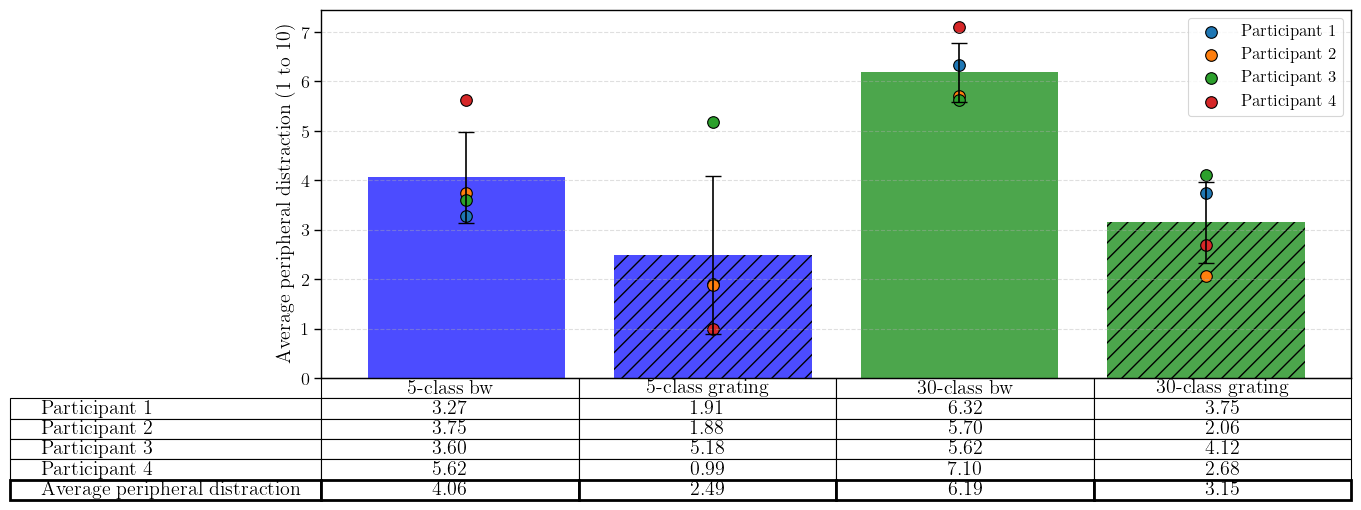

In [37]:
distr_5bw = [P1_distr_5bw,P2_distr_5bw,P3_distr_5bw,P4_distr_5bw]
distr_30bw = [P1_distr_30bw, P2_distr_30bw,P3_distr_30bw,P4_distr_30bw]
distr_5g = [P1_distr_5g, P2_distr_5g, P3_distr_5g, P4_distr_5g] 
distr_30g = [P1_distr_30g,P2_distr_30g,P3_distr_30g,P4_distr_30g]

distr_5bw_averaged = np.mean(distr_5bw, axis = 1)
distr_5bw_mean = np.mean(distr_5bw_averaged)
distr_5bw_std = np.std(distr_5bw_averaged)

distr_30bw_averaged = np.mean(distr_30bw, axis = 1)
distr_30bw_mean = np.mean(distr_30bw_averaged)
distr_30bw_std = np.std(distr_30bw_averaged)

distr_5g_averaged = np.mean(distr_5g, axis = 1)
distr_5g_mean = np.mean(distr_5g_averaged)
distr_5g_std = np.std(distr_5g_averaged)

distr_30g_averaged = np.mean(distr_30g, axis = 1)
distr_30g_mean = np.mean(distr_30g_averaged)
distr_30g_std = np.std(distr_30g_averaged)

distr = [distr_5bw_mean, distr_5g_mean, distr_30bw_mean, distr_30g_mean]
distr_std = [distr_5bw_std,distr_5g_std,distr_30bw_std,distr_30g_std]

distr_per_participant = np.array([
    distr_5bw_averaged,
    distr_5g_averaged,
    distr_30bw_averaged,
    distr_30g_averaged
]).T

print(f"amount of eyestrain for 5bw: {distr_5bw_mean}")
print(f"amount of eyestrain for 30bw: {distr_30bw_mean}")
print(f"amount of eyestrain for 5g: {distr_5g_mean}")
print(f"amount of eyestrain for 30g: {distr_30g_mean}")

print(f"LOLOLOL {distr_30g}")
conditions = [
    "5-class BW",
    "5-class Grating",
    "30-class BW",
    "30-class Grating"
]
x = np.arange(len(conditions))

# Plot bar chart with error bars
plt.figure(figsize=(11.69, 6))
for i in range(len(x)):
    bars = plt.bar(x[i], distr[i], yerr = distr_std[i], capsize=6, alpha=0.7, color = colors[i], hatch = hatches[i])

# Overlay individual participant data as dots
for i, participant in enumerate(distr_per_participant):
    plt.scatter(x, participant, label=f"Participant {i+1}", s=70, edgecolors='k')

# Final plot details
plt.xticks(x, conditions)
plt.ylabel("Average peripheral distraction (1 to 10)")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.legend(loc='upper right', fontsize = 'small')

columns = ('5-class bw', '5-class grating', '30-class bw', '30-class grating')
rows = ["Participant 1 ","Participant 2", "Participant 3", "Participant 4","Average peripheral distraction"]
# Format the cell text: round to 3 or 4 decimal places
cell_text = [[f"{val:.2f}" for val in participant] for participant in distr_per_participant]
cell_text.append([f"{val:.2f}" for val in distr])


# Add a table at the bottom of the axes
the_table = plt.table(cellText=cell_text,
                      rowLabels=rows,
                      colLabels=columns,
                      loc='bottom',
                      cellLoc='center')

# Adjust layout to make room for the table:
the_table.auto_set_font_size(True)

plt.subplots_adjust(left=0.1, bottom=0.35)  # or try 0.4

the_table.scale(1, 1.75) 

# Bold the "Average" row text and increase border thickness
for col in range(n_cols):
    cell = the_table[(n_rows, col)]  # fifth row (index 4)
    cell.set_text_props(weight='bold')
    cell.set_linewidth(2)  # bold cell border

# Bold the row label "Average"
the_table[(n_rows, -1)].set_text_props(weight='bold')
the_table[(n_rows, -1)].set_linewidth(2)

plt.xticks([], [])  # This removes both ticks and tick labels on the x-axis


filename = "distr_plot"
plt.savefig(filename, bbox_inches='tight', transparent=False, pad_inches=0.1)
plt.show()

In [38]:
import pandas as pd

# Flat list of participants and conditions
data = []
conditions = ["5-class BW", "5-class Grating", "30-class BW", "30-class Grating"]

for pid, p in enumerate(distr_per_participant, start=1):
    for cond, acc in zip(conditions, p):
        data.append({
            'Participant': f'P{pid}',
            'Condition': cond,
            'Distraction': acc
        })

df = pd.DataFrame(data)

# Create new columns for the two within-subject factors
df['Classes'] = df['Condition'].apply(lambda x: '5' if '5-class' in x else '30')
df['Appearance'] = df['Condition'].apply(lambda x: 'bw' if 'BW' in x else 'grating')

print(df)

anova = AnovaRM(df, depvar='Distraction', subject='Participant', within=['Classes', 'Appearance']).fit()
print(anova)

   Participant         Condition  Distraction Classes Appearance
0           P1        5-class BW     3.272059       5         bw
1           P1   5-class Grating     1.911765       5    grating
2           P1       30-class BW     6.323529      30         bw
3           P1  30-class Grating     3.750000      30    grating
4           P2        5-class BW     3.750000       5         bw
5           P2   5-class Grating     1.875000       5    grating
6           P2       30-class BW     5.698529      30         bw
7           P2  30-class Grating     2.058824      30    grating
8           P3        5-class BW     3.602941       5         bw
9           P3   5-class Grating     5.183824       5    grating
10          P3       30-class BW     5.625000      30         bw
11          P3  30-class Grating     4.117647      30    grating
12          P4        5-class BW     5.625000       5         bw
13          P4   5-class Grating     0.992647       5    grating
14          P4       30-c

In [40]:
import numpy as np
from scipy.stats import ttest_rel

distr_5 = df[df['Classes'] == '5'].groupby('Participant')['Distraction'].mean()
distr_30 = df[df['Classes'] == '30'].groupby('Participant')['Distraction'].mean()
print(distr_5)
print(distr_30)

# Post-HOC ITR_30 > ITR_5
t_stat, p_two_sided = ttest_rel(distr_30, distr_5)
print(t_stat)
print(p_two_sided)
if t_stat > 0:
    p_one_sided = p_two_sided /2
else:
    p_one_sided = 1 - (p_two_sided /2)

# Print results
print(f"Post-hoc one-sided t-test that the 30 class condition results in a higher peripher distraction score")
print(f"t({len(itr_5)-1}) = {t_stat:.3f}, one-sided p = {p_one_sided:.7f}")



Participant
P1    2.591912
P2    2.812500
P3    4.393382
P4    3.308824
Name: Distraction, dtype: float64
Participant
P1    5.036765
P2    3.878676
P3    4.871324
P4    4.889706
Name: Distraction, dtype: float64
3.339903478672861
0.04439065954485679
Post-hoc one-sided t-test that the 30 class condition results in a higher ITR
t(3) = 3.340, one-sided p = 0.0221953
